# Figure 3: Declining radial profile of Magellanic Corona.


In [63]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.table import QTable
%matplotlib notebook

import seaborn as sns
pal = sns.color_palette("colorblind")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [68]:
#Load Data
with open("Data/HIGH_ION_MAP_DATA.pkl", "rb") as f:
    high_ion_data = pickle.load(f)
    
# Extra Data for OVI
full_ideal_res = QTable.read("Data/Full_Ideal_CloudyResults_wNHII.fits")
good_OVI = np.invert(np.isnan(full_ideal_res["MEAS_N_OVI"]))
good_OVI &= full_ideal_res["MEAS_V_CIV"] > 150*u.km/u.s
# Remove one bad fit source
good_OVI &= full_ideal_res["SOURCE"] != "HE0226-4110"
OVI_data_full = full_ideal_res[good_OVI]

# Manual Measurement changes based on newer fits
# OVI_data_full[0]["MEAS_N_OVI"] = 10**14.03 * u.cm**-2
# OVI_data_full[0]["MEAS_ERR_N_OVI"] = 0.13 * np.log(10) * 10**14.03 * u.cm**-2

# OVI_data_full[1]["MEAS_N_OVI"] = 10**13.9 * u.cm**-2
# OVI_data_full[1]["MEAS_ERR_N_OVI"] = 0.22 * np.log(10) * 10**13.9 * u.cm**-2

OVI_data_full[2]["MEAS_N_OVI"] = 10**14.17 * u.cm**-2
OVI_data_full[2]["MEAS_ERR_N_OVI"] = 0.11 * np.log(10) * 10**14.17 * u.cm**-2

OVI_data_full[3]["MEAS_N_OVI"] = 10**14.33 * u.cm**-2
OVI_data_full[3]["MEAS_ERR_N_OVI"] = 0.1 * np.log(10) * 10**14.33 * u.cm**-2



In [69]:
OVI_data_full

SOURCE,COMP_NUM,n_H,PHI(H),N_HI,N_HII,N_SiII,N_SiIII,N_SiIV,N_CII,N_CIV,N_FeII,N_AlII,N_NI,N_SII,N_OI,N_OVI,Te,STOP_COL_REACHED,bg_n_H,bg_PHI(H),bg_N_HI,bg_N_HII,bg_N_SiII,bg_N_SiIII,bg_N_SiIV,bg_N_CII,bg_N_CIV,bg_N_FeII,bg_N_AlII,bg_N_NI,bg_N_SII,bg_N_OI,bg_N_OVI,bg_Te,bg_STOP_COL_REACHED,v,MEAS_V_CIV,MEAS_N_CIV,MEAS_ERR_N_CIV,B_CIV,ERR_B_CIV,MEAS_N_SiIV,MEAS_ERR_N_SiIV,B_SiIV,ERR_B_SiIV,MEAS_N_OVI,MEAS_ERR_N_OVI,B_OVI,ERR_B_OVI,LOW_v,MEAS_N_CII,MEAS_ERR_N_CII,B_CII,ERR_B_CII,MEAS_N_SiII,MEAS_ERR_N_SiII,B_SiII,ERR_B_SiII,MEAS_N_AlII,MEAS_ERR_N_AlII,B_AlII,ERR_B_AlII,LMC_B,CIV_to_SiIV,OVI_to_SiIV,OVI_to_CIV,CIV_to_SiIV_err,OVI_to_SiIV_err,OVI_to_CIV_err,CIV_to_SiIV_LL,OVI_to_SiIV_LL,OVI_to_CIV_LL,CIV_to_SiIV_UL,OVI_to_SiIV_UL,OVI_to_CIV_UL,CIV_to_SiIV_BAD,OVI_to_SiIV_BAD,OVI_to_CIV_BAD,RATIO_LOGT_FIRST,RATIO_LOGT_FIRST_ERR,RATIO_LOGT_SECOND,RATIO_LOGT_SECOND_ERR,RATIO_LOGT_THIRD,RATIO_LOGT_THIRD_ERR,N_HII_FIRST_CIV,N_HII_FIRST_CIV_ERR,N_HII_FIRST_SiIV,N_HII_FIRST_SiIV_ERR,N_HII_SECOND_CIV,N_HII_SECOND_CIV_ERR,N_HII_SECOND_SiIV,N_HII_SECOND_SiIV_ERR,N_HII_THIRD_CIV,N_HII_THIRD_CIV_ERR,N_HII_THIRD_SiIV,N_HII_THIRD_SiIV_ERR,N_HII_BAD,N_HII_BAD_CIV,N_HII_BAD_SiIV,RATIO_LOGT_ISOCh,RATIO_LOGT_ISOCh_ERR,RATIO_LOGT_ISOB,RATIO_LOGT_ISOB_ERR,N_HII_ISOCh_CIV,N_HII_ISOCh_CIV_ERR,N_HII_ISOCh_SiIV,N_HII_ISOCh_SiIV_ERR,N_HII_ISOB_CIV,N_HII_ISOB_CIV_ERR,N_HII_ISOB_SiIV,N_HII_ISOB_SiIV_ERR
,,1 / cm3,ph / s,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,K,,1 / cm3,ph / s,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,K,,km / s,km / s,1 / cm2,1 / cm2,km / s,km / s,1 / cm2,1 / cm2,km / s,km / s,1 / cm2,1 / cm2,km / s,km / s,km / s,1 / cm2,1 / cm2,km / s,km / s,1 / cm2,1 / cm2,km / s,km / s,1 / cm2,1 / cm2,km / s,km / s,kpc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes23,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1H0419-577,5,0.018921693353828553,159342.63695087915,3.45115e+16,2.58218e+18,6558350000000.0,12670400000000.0,171587000000.0,69873600000000.0,154597000000.0,1260440000000.0,1416410000000.0,293924000000.0,4070410000000.0,3697390000000.0,56270.9,12416.523075924119,True,0.1856312119051715,40830.5283724255,2.66013e+17,5.54945e+17,5940530000000.0,117483000000.0,279398000.0,39371100000000.0,0.0,4482950000000.0,509878000000.0,4000480000000.0,3022300000000.0,32136700000000.0,0.0,16255.48755750485,True,322.50101914736825,325.7611807041106,35253143168375.836,2514095669599.2656,24.058009191376968,2.1326604497028097,5346526902066.543,686082125362.6395,14.277918677622548,2.6619559244839945,106131677818202.19,31089922050860.027,16.4715948425997,8.395795918259788,343.4109659793403,79574137999387.92,6687538158709.308,14.951045732022937,1.3448844477220816,4869814241081.894,347817628908.0548,16.67440457906782,1.4597198040547066,571265732298.6941,843047219150.5366,nan,nan,12.486540411593717,0.8191260883264029,1.2977732735735454,0.47864718524714256,0.08670188061914064,0.18295098288536057,0.15819296191407586,False,False,False,False,False,False,False,False,False,4.955816890378417,0.008577986090683368,5.14572767985559,6.226130722097878e-13,5.52763763304944

In [118]:
# Prepare OVI data:
OVI_data = {"OVI":[], "OVI_err":[], "LMC_B":[], "SOURCE":[]}
for source in np.unique(OVI_data_full["SOURCE"]):
    mask = OVI_data_full["SOURCE"] == source
    
    OVI_data["OVI"].append(np.sum(OVI_data_full[mask]["MEAS_N_OVI"]).value)
    OVI_data["OVI_err"].append(np.sum(OVI_data_full[mask]["MEAS_ERR_N_OVI"]).value)
    

    
    OVI_data["LMC_B"].append(OVI_data_full[mask]["LMC_B"][0].value)
    OVI_data["SOURCE"].append(source)
    
    

    

for key in OVI_data.keys():
    OVI_data[key] = np.array(OVI_data[key])
    

# Manual addition for IRAS_Z06229-634
OVI_data["OVI"] = np.append(OVI_data["OVI"],np.sum([10**14.07, 10**14.30, 10**14.07]))
OVI_data["OVI_err"] = np.append(OVI_data["OVI_err"],np.sum([10**14.07 * np.log(10) * 0.14, 
                                                            10**14.30 * np.log(10) * 0.11, 
                                                            10**14.07 * np.log(10) * 0.16]))
OVI_data["LMC_B"] = np.append(OVI_data["LMC_B"],6.8)
OVI_data["SOURCE"] = np.append(OVI_data["SOURCE"],"IRAS_Z06229-634")

    
OVI_data["OVI_err"] = 1/np.log(10) * OVI_data["OVI_err"]/OVI_data["OVI"]
OVI_data["OVI"] = np.log10(OVI_data["OVI"])


# Manual addition for RBS144
OVI_data["OVI"] = np.append(OVI_data["OVI"], [13.88])
OVI_data["OVI_err"] = np.append(OVI_data["OVI_err"],0.12)
OVI_data["LMC_B"] = np.append(OVI_data["LMC_B"],34.8)
OVI_data["SOURCE"] = np.append(OVI_data["SOURCE"],"RBS144")

# Manual addition for HE0226-4110
OVI_data["OVI"] = np.append(OVI_data["OVI"],13.72)
OVI_data["OVI_err"] = np.append(OVI_data["OVI_err"],0.13)
OVI_data["LMC_B"] = np.append(OVI_data["LMC_B"],37.0)
OVI_data["SOURCE"] = np.append(OVI_data["SOURCE"],"HE0226-4110")



OVI_data["LMC_B"] *= u.kpc





In [119]:
OVI_data

{'OVI': array([14.26769322, 14.55835697, 14.03921102, 14.63799552, 13.88      ,
        13.72      ]),
 'OVI_err': array([0.16597611, 0.10408924, 0.10288315, 0.13163189, 0.12      ,
        0.13      ]),
 'LMC_B': <Quantity [12.48654041,  9.86112393, 42.86609215,  6.8       , 34.8       ,
            37.        ] kpc>,
 'SOURCE': array(['1H0419-577', 'ESO031-G08', 'IRAS_F21325-6237', 'IRAS_Z06229-634',
        'RBS144', 'HE0226-4110'], dtype='<U16')}

In [6]:
# Prepare Data for Stat Tests

XX = high_ion_data["b"]

no_meas = np.isnan(high_ion_data["SiIV"])
no_meas = np.isnan(high_ion_data["SiIV_err"])
no_meas |= np.isinf(high_ion_data["SiIV"])

YY = np.copy(high_ion_data["SiIV"])
YY_err = np.copy(high_ion_data["SiIV_err"])
has_UL = np.isnan(high_ion_data["SiIV_UL"]) | np.isinf(high_ion_data["SiIV_UL"])
has_UL = np.invert(has_UL)
meas_S = ~no_meas
YY[no_meas] = high_ion_data["SiIV_UL"][no_meas]
YY_err[no_meas & has_UL] = -1.

good_vals = has_UL | ~no_meas


Ylim = np.zeros_like(XX, dtype = int)
Ylim[has_UL & no_meas] = 1

Xlim = np.zeros_like(XX, dtype = int)

coeff = "kendallt"
Nboot = 10000

xS = XX[good_vals]
yS = YY[good_vals]
yS_err = YY_err[good_vals]
xlimS = Xlim[good_vals]
ylimS = Ylim[good_vals]

kwargs = {"return_dist":True}

# Correlation Test for Si
res = pymccorrelation(xS, yS, xlim = xlimS, ylim = ylimS, 
            coeff = coeff, Nboot = Nboot, **kwargs)


out = {}

out["coeff_percentiles"] = res[0]
out["p-value_percentiles"] = res[1]
out["coeff_dist"] = res[2]
out["p-value_dist"] = res[3]




no_meas = np.isnan(high_ion_data["CIV"])
no_meas = np.isnan(high_ion_data["CIV_err"])
no_meas |= np.isinf(high_ion_data["CIV"])
meas_C = ~no_meas

YY = np.copy(high_ion_data["CIV"])
YY_err = np.copy(high_ion_data["CIV_err"])
has_UL = np.isnan(high_ion_data["CIV_UL"]) | np.isinf(high_ion_data["CIV_UL"])
has_UL = np.invert(has_UL)
YY[no_meas] = high_ion_data["CIV_UL"][no_meas]
YY_err[no_meas & has_UL] = -1.

good_vals = has_UL | ~no_meas


Ylim = np.zeros_like(XX, dtype = int)
Ylim[has_UL&no_meas] = 1

Xlim = np.zeros_like(XX, dtype = int)

coeff = "kendallt"
Nboot = 10000

xC = XX[good_vals]
yC = YY[good_vals]
yC_err = YY_err[good_vals]
xlimC = Xlim[good_vals]
ylimC = Ylim[good_vals]

kwargs = {"return_dist":True}


# Correlation Test for C
res = pymccorrelation(xC, yC, xlim = xlimC, ylim = ylimC, 
            coeff = coeff, Nboot = Nboot, **kwargs)


outC = {}

outC["coeff_percentiles"] = res[0]
outC["p-value_percentiles"] = res[1]
outC["coeff_dist"] = res[2]
outC["p-value_dist"] = res[3]





mc_data = {
    "Ion":np.concatenate([["SiIV"]*len(out["coeff_dist"]),["CIV"]*len(outC["coeff_dist"])]),
    r"Kendall's $\tau$":np.concatenate([out["coeff_dist"], outC["coeff_dist"]]),
    r"$\log_{10}$(p-value)":np.log10(np.concatenate([out["p-value_dist"], outC["p-value_dist"]]))
}






In [120]:

OVI_KendallTau = kendalltau(OVI_data["LMC_B"], OVI_data["OVI"])
print(OVI_KendallTau)


def boot_OVI_tau(inds):
    x = OVI_data["LMC_B"][inds]
    y = OVI_data["OVI"] + np.random.randn(len(inds)) * OVI_data["OVI_err"]
    return kendalltau(x, y)

boot_OVI_KendallTau = 

print(np.percentile(boot_OVI_KendallTau[:,1][~np.isnan(boot_OVI_KendallTau[:,1])], (16,50,84)))
print(np.percentile(boot_OVI_KendallTau[:,0][~np.isnan(boot_OVI_KendallTau[:,0])], (16,50,84)))

KendalltauResult(correlation=-0.7333333333333333, pvalue=0.05555555555555555)
[0.15017991 0.44421673 0.84549398]
[-0.38924947  0.          0.38924947]


In [8]:
# Correlation Test for points with rho>7 kpc

gt7_maskC = xC>7
gt7_resC = pymccorrelation(xC[gt7_maskC], yC[gt7_maskC], 
                           xlim = xlimC[gt7_maskC], ylim = ylimC[gt7_maskC], 
            coeff = coeff, Nboot = Nboot, **kwargs)

gt7_maskS = xS>7
gt7_resS = pymccorrelation(xS[gt7_maskS], yS[gt7_maskS], 
                           xlim = xlimS[gt7_maskS], ylim = ylimS[gt7_maskS], 
            coeff = coeff, Nboot = Nboot, **kwargs)

In [9]:
gt7_outC = {}

gt7_outC["coeff_percentiles"] = gt7_resC[0]
gt7_outC["p-value_percentiles"] = gt7_resC[1]
gt7_outC["coeff_dist"] = gt7_resC[2]
gt7_outC["p-value_dist"] = gt7_resC[3]

gt7_out = {}

gt7_out["coeff_percentiles"] = gt7_resS[0]
gt7_out["p-value_percentiles"] = gt7_resS[1]
gt7_out["coeff_dist"] = gt7_resS[2]
gt7_out["p-value_dist"] = gt7_resS[3]



gt7_mc_data = {
    "Ion":np.concatenate([["SiIV"]*len(gt7_out["coeff_dist"]),["CIV"]*len(gt7_outC["coeff_dist"])]),
    r"Kendall's $\tau$":np.concatenate([gt7_out["coeff_dist"], gt7_outC["coeff_dist"]]),
    r"$\log_{10}$(p-value)":np.log10(np.concatenate([gt7_out["p-value_dist"], gt7_outC["p-value_dist"]]))
}

In [10]:
# Specify Bridge and Stream Directions

sn = ['PKS0637-75',
 'HE0246-4101',
 'RBS144',
 'PKS0552-640',
 'PKS0202-76',
 'HE0003-5023',
 'UVQSJ045415.95-611626.6',
 'HE0419-5657',
 'UKS0242-724',
 'IRAS_F21325-6237',
 'IRAS_Z06229-6434',
 'RBS567',
 'PKS0558-504',
 'RX_J0503.1-6634',
 '1H0419-577',
 'RBS1992',
 'ESO031-G08',
 'PKS0355-483',
 'HE0153-4520',
 'HE0439-5254',
 'HE0038-5114',
 'HE0226-4110',
 'HE2336-5540',
 'RBS563',
 'HE0331-4112',
 'HE0435-5304',
 'HE2305-5315',
 'FAIRALL9']


bridge_directions = [
    "PKS0202-76",
    "UKS0242-724",
    "ESO031-G08"
]


stream_directions = [
    "RBS144",
    "HE0226-4110",
    "HE0153-4520",
    "FAIRALL9"
]

stream_mask = np.array([n in stream_directions for n in sn])
stream_Bs = XX[stream_mask]

bridge_mask = np.array([n in bridge_directions for n in sn])
bridge_Bs = XX[bridge_mask]

rest_mask = ~stream_mask & ~bridge_mask

In [11]:
# Linear Regression
## All Data

upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0

delta_C = np.invert(upper_lim_C)
xsig_C = np.zeros_like(xC)
ysig_C = yC_err[:]
lmcens_C = linmix.LinMix(xC, yC, xsig_C, ysig_C, delta=delta_C, K=2)
lmcens_C.run_mcmc(silent=True)

yints_C = lmcens_C.chain['alpha']
slopes_C = lmcens_C.chain['beta']


mean_yint_C = yints_C.mean()
mean_slope_C = slopes_C.mean()

xx = np.linspace(0,50,1000)
all_lines_C = np.array([m*xx + b for (m,b) in zip(slopes_C, yints_C)])

lo_line_C, med_line_C, hi_line_C = np.percentile(all_lines_C, (16,50,84), axis = 0)
mean_line_C = mean_slope_C*xx + mean_yint_C


delta_S = np.invert(upper_lim_S)
xsig_S = np.zeros_like(xS)
ysig_S = yS_err[:]
lmcens_S = linmix.LinMix(xS, yS, xsig_S, ysig_S, delta=delta_S, K=2)
lmcens_S.run_mcmc(silent=True)

yints_S = lmcens_S.chain['alpha']
slopes_S = lmcens_S.chain['beta']


mean_yint_S = yints_S.mean()
mean_slope_S = slopes_S.mean()

xx = np.linspace(0,50,1000)
all_lines_S = np.array([m*xx + b for (m,b) in zip(slopes_S, yints_S)])

lo_line_S, med_line_S, hi_line_S = np.percentile(all_lines_S, (16,50,84), axis = 0)
mean_line_S = mean_slope_S*xx + mean_yint_S






In [121]:
# OVI
from scipy.stats import siegelslopes
from seaborn.algorithms import bootstrap


def slope_finder(inds, y = OVI_data["OVI"], x = OVI_data["LMC_B"], y_err = OVI_data["OVI_err"]):
    xx = x[inds]
    yy = y[inds] + y_err * np.random.randn(len(inds))
    return siegelslopes(yy, x = xx)

slope_O, intercept_O = bootstrap(np.arange(len(OVI_data["LMC_B"])), func = slope_finder, n_boot = 10000).T
slope_O = slope_O[~np.isnan(slope_O)]
intercept_O = intercept_O[~np.isnan(intercept_O)]

mean_slope_O = slope_O.mean()
mean_yint_O = intercept_O.mean()
std_slope_O = slope_O.std()

O_xx = np.linspace(0,50,1000)
all_lines_O = np.array([m*O_xx + b for (m,b) in zip(slope_O, intercept_O)])


lo_line_O, med_line_O, hi_line_O = np.percentile(all_lines_O, (16,50,84), axis = 0)
mean_line_O = mean_slope_O*xx + mean_yint_O

/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [127]:
O_xx = np.linspace(OVI_data['LMC_B'].min().value,OVI_data['LMC_B'].max().value ,1000)
print(O_xx.min(), O_xx.max())
# O_xx = np.linspace(0,500,1000)

6.8 42.866092148258666


In [128]:
#OVI based HII Mass
OVI_data["HII_CIE"] = OVI_data["OVI"] + 3.97756
OVI_data["HII_ISOB"] = OVI_data["OVI"] + 5.04755
OVI_data["HII_ISOCh"] = OVI_data["OVI"] + 5.08469

OVI_data["HII_CIE_err"] = OVI_data["OVI_err"]
OVI_data["HII_ISOB_err"] = OVI_data["OVI_err"]
OVI_data["HII_ISOCh_err"] = OVI_data["OVI_err"]

all_lines_O_HII_CIE = all_lines_O + 3.97756
all_lines_O_HII_ISOB = all_lines_O + 5.04755
all_lines_O_HII_ISOCh = all_lines_O + 5.08469

distance = 50*u.kpc
from astropy.constants import m_p as proton_mass


dr = np.diff(O_xx)[0]*u.kpc
dA = 2*np.pi*O_xx*u.kpc*dr
mass_CIE = dA * proton_mass * (10**all_lines_O_HII_CIE)*u.cm**(-2)
mass_ISOB = dA * proton_mass * (10**all_lines_O_HII_ISOB)*u.cm**(-2)
mass_ISOCh = dA * proton_mass * (10**all_lines_O_HII_ISOCh)*u.cm**(-2)

under_30_mask = xx < 30
fcov_in = 0.78
fcov_out = 0.3

summed_masses_50_kpc_CIE = np.sum(mass_CIE[:,under_30_mask].to(u.Msun), axis = 1) * fcov_in
summed_masses_50_kpc_CIE += np.sum(mass_CIE[:,~under_30_mask].to(u.Msun), axis = 1) * fcov_out
lo_mass_CIE, med_mass_CIE, hi_mass_CIE = np.percentile(np.log10(summed_masses_50_kpc_CIE.value), (16,50,84))

lo_err_mass_CIE = med_mass_CIE - lo_mass_CIE
hi_err_mass_CIE = hi_mass_CIE - med_mass_CIE

print("CIE:", med_mass_CIE, "+", hi_err_mass_CIE, "-", lo_err_mass_CIE)

summed_masses_50_kpc_ISOB = np.sum(mass_ISOB[:,under_30_mask].to(u.Msun), axis = 1) * fcov_in
summed_masses_50_kpc_ISOB += np.sum(mass_ISOB[:,~under_30_mask].to(u.Msun), axis = 1) * fcov_out
lo_mass_ISOB, med_mass_ISOB, hi_mass_ISOB = np.percentile(np.log10(summed_masses_50_kpc_ISOB.value), (16,50,84))

lo_err_mass_ISOB = med_mass_ISOB - lo_mass_ISOB
hi_err_mass_ISOB = hi_mass_ISOB - med_mass_ISOB

print("ISOB:", med_mass_ISOB, "+", hi_err_mass_ISOB, "-", lo_err_mass_ISOB)

summed_masses_50_kpc_ISOCh = np.sum(mass_ISOCh[:,under_30_mask].to(u.Msun), axis = 1) * fcov_in
summed_masses_50_kpc_ISOCh += np.sum(mass_ISOCh[:,~under_30_mask].to(u.Msun), axis = 1) * fcov_out
lo_mass_ISOCh, med_mass_ISOCh, hi_mass_ISOCh = np.percentile(np.log10(summed_masses_50_kpc_ISOCh.value), (16,50,84))

lo_err_mass_ISOCh = med_mass_ISOCh - lo_mass_ISOCh
hi_err_mass_ISOCh = hi_mass_ISOCh - med_mass_ISOCh

print("ISOCh:", med_mass_ISOCh, "+", hi_err_mass_ISOCh, "-", lo_err_mass_ISOCh)


CIE: 7.54191345930246 + 0.10850371173434947 - 0.12956806002662358
ISOB: 8.61190345930246 + 0.10850371173435036 - 0.1295680600266227
ISOCh: 8.649043459302462 + 0.10850371173434858 - 0.12956806002662447


In [129]:
# Total Mass Estimate
print("Total Log Mass = ",np.log10(10**8.8 + 10**8.4 + 10**8.6))


Total Log Mass =  9.107295855844434


In [110]:
OVI_data["CIE_MASS"] = (med_mass_CIE,hi_err_mass_CIE,lo_err_mass_CIE)

OVI_data["ISOB_MASS"] = (med_mass_ISOB,hi_err_mass_ISOB,lo_err_mass_ISOB)

OVI_data["ISOCh_MASS"] = (med_mass_ISOCh,hi_err_mass_ISOCh,lo_err_mass_ISOCh)

OVI_data["XX"] = O_xx
OVI_data["MEAN_LINE_CIE"] = mean_line_O + 3.97756
OVI_data["MEAN_LINE_ISOB"] = mean_line_O + 5.04755
OVI_data["MEAN_LINE_ISOCh"] = mean_line_O + 5.08469

OVI_data["LO_LINE_CIE"] = lo_line_O + 3.97756
OVI_data["LO_LINE_ISOB"] = lo_line_O + 5.04755
OVI_data["LO_LINE_ISOCh"] = lo_line_O + 5.08469

OVI_data["HI_LINE_CIE"] = hi_line_O + 3.97756
OVI_data["HI_LINE_ISOB"] = hi_line_O + 5.04755
OVI_data["HI_LINE_ISOCh"] = hi_line_O + 5.08469



with open("Data/OVI_Data.pkl", "wb") as f:
    pickle.dump(OVI_data, f)

In [111]:
OVI_data

{'OVI': array([14.26769322, 14.6580424 , 14.03921102, 14.63799552, 13.88      ,
        13.72      ]),
 'OVI_err': array([0.16597611, 0.11965825, 0.10288315, 0.13163189, 0.12      ,
        0.13      ]),
 'LMC_B': <Quantity [12.48654041,  9.86112393, 42.86609215,  6.8       , 34.8       ,
            37.        ] kpc>,
 'SOURCE': array(['1H0419-577', 'ESO031-G08', 'IRAS_F21325-6237', 'IRAS_Z06229-634',
        'RBS144', 'HE0226-4110'], dtype='<U16'),
 'HII_CIE': array([18.24525322, 18.6356024 , 18.01677102, 18.61555552, 17.85756   ,
        17.69756   ]),
 'HII_ISOB': array([19.31524322, 19.7055924 , 19.08676102, 19.68554552, 18.92755   ,
        18.76755   ]),
 'HII_ISOCh': array([19.35238322, 19.7427324 , 19.12390102, 19.72268552, 18.96469   ,
        18.80469   ]),
 'HII_CIE_err': array([0.16597611, 0.11965825, 0.10288315, 0.13163189, 0.12      ,
        0.13      ]),
 'HII_ISOB_err': array([0.16597611, 0.11965825, 0.10288315, 0.13163189, 0.12      ,
        0.13      ]),
 'HII_ISOC

In [17]:
# Linear Regression
## rho > 7 kpc

upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0

delta_C = np.invert(upper_lim_C)
xsig_C = np.zeros_like(xC)
ysig_C = yC_err[:]
lmcens_C = linmix.LinMix(xC[xC>7], yC[xC>7], xsig_C[xC>7], ysig_C[xC>7], delta=delta_C[xC>7], K=2)
lmcens_C.run_mcmc(silent=True)

yints_C = lmcens_C.chain['alpha']
slopes_C = lmcens_C.chain['beta']


mean_yint_C = yints_C.mean()
mean_slope_C = slopes_C.mean()

gt7_xx = np.linspace(0,50,1000)
all_lines_C = np.array([m*gt7_xx + b for (m,b) in zip(slopes_C, yints_C)])

gt7_lo_line_C, gt7_med_line_C, gt7_hi_line_C = np.percentile(all_lines_C, (16,50,84), axis = 0)
gt7_mean_line_C = mean_slope_C*gt7_xx + mean_yint_C


delta_S = np.invert(upper_lim_S)
xsig_S = np.zeros_like(xS)
ysig_S = yS_err[:]
lmcens_S = linmix.LinMix(xS[xS>7], yS[xS>7], xsig_S[xS>7], ysig_S[xS>7], delta=delta_S[xS>7], K=2)
lmcens_S.run_mcmc(silent=True)

yints_S = lmcens_S.chain['alpha']
slopes_S = lmcens_S.chain['beta']


mean_yint_S = yints_S.mean()
mean_slope_S = slopes_S.mean()

gt7_xx = np.linspace(0,50,1000)
all_lines_S = np.array([m*gt7_xx + b for (m,b) in zip(slopes_S, yints_S)])

gt7_lo_line_S, gt7_med_line_S, gt7_hi_line_S = np.percentile(all_lines_S, (16,50,84), axis = 0)
gt7_mean_line_S = mean_slope_S*gt7_xx + mean_yint_S

## Figure 3

<IPython.core.display.Javascript object>


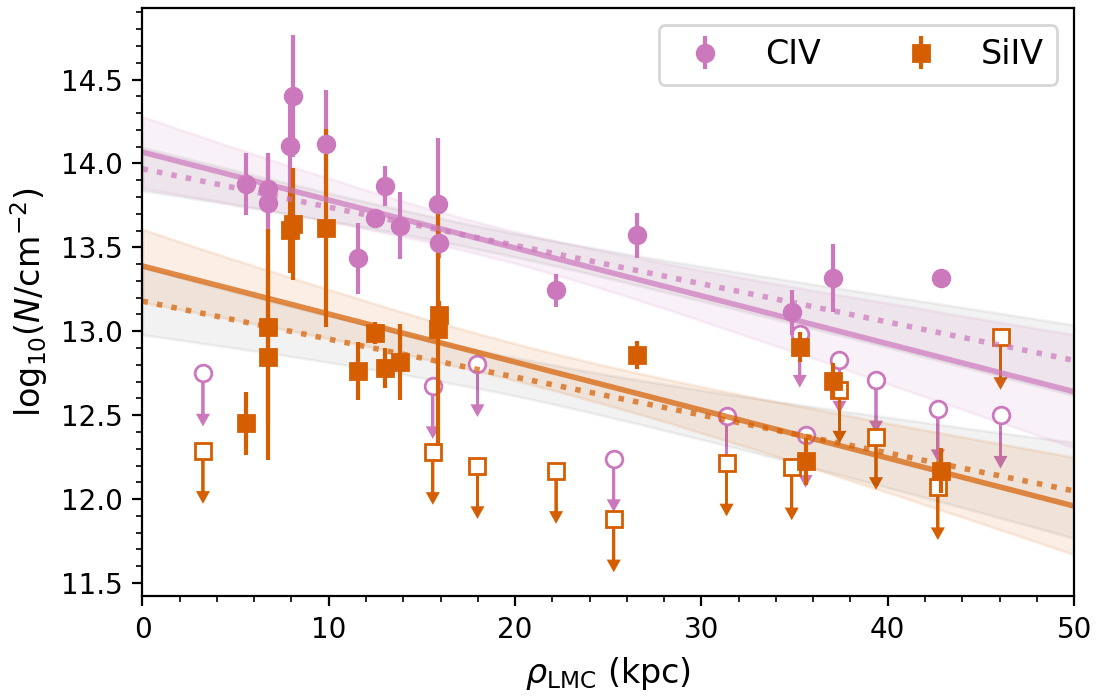

(0.0, 50.0)

In [18]:
fig,ax = plt.subplots(constrained_layout = True, figsize = (5.5, 3.5))

axd = {"A":ax}


palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0



axd["A"].plot(xC[upper_lim_C], yC[upper_lim_C], "o",
                 markeredgecolor = palette[1], markerfacecolor = "w", markersize = 6)


axd["A"].plot(xS[upper_lim_S], yS[upper_lim_S], "s",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

#add arrows
for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




axd["A"].errorbar(xC[~upper_lim_C], yC[~upper_lim_C], 
                  yC_err[~upper_lim_C], fmt = "o", 
                  color=palette[1], label = "CIV")
axd["A"].errorbar(xS[~upper_lim_S], yS[~upper_lim_S], 
                  yS_err[~upper_lim_S], fmt = "s",
                  color=palette[0], label = "SiIV")



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)



xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlim(0,50)

# fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/Figure3.png", dpi = 300, 
#             transparent = True)
# fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/Figure3.svg", 
#             transparent = True)

In [19]:
OVI_data

{'OVI': array([14.26769322, 14.28524174, 13.92936691, 14.03921102, 14.01      ]),
 'OVI_err': array([0.16597611, 0.38622434, 0.71674072, 0.10288315, 0.08      ]),
 'LMC_B': <Quantity [12.48654041,  9.86112393, 37.04679733, 42.86609215, 34.8       ] kpc>,
 'SOURCE': array(['1H0419-577', 'ESO031-G08', 'HE0226-4110', 'IRAS_F21325-6237',
        'RBS144'], dtype='<U16'),
 'HII_CIE': array([18.24525322, 18.26280174, 17.90692691, 18.01677102, 17.98756   ]),
 'HII_ISOB': array([19.31524322, 19.33279174, 18.97691691, 19.08676102, 19.05755   ]),
 'HII_ISOCh': array([19.35238322, 19.36993174, 19.01405691, 19.12390102, 19.09469   ]),
 'HII_CIE_err': array([0.16597611, 0.38622434, 0.71674072, 0.10288315, 0.08      ]),
 'HII_ISOB_err': array([0.16597611, 0.38622434, 0.71674072, 0.10288315, 0.08      ]),
 'HII_ISOCh_err': array([0.16597611, 0.38622434, 0.71674072, 0.10288315, 0.08      ]),
 'CIE_MASS': (7.563833150482841, 0.22162291902607478, 0.16341958233760323),
 'ISOB_MASS': (8.63382315048284, 0.

In [112]:
OVI_upper_lim_H2 = np.array([False, False, False, False, False, False])

<IPython.core.display.Javascript object>


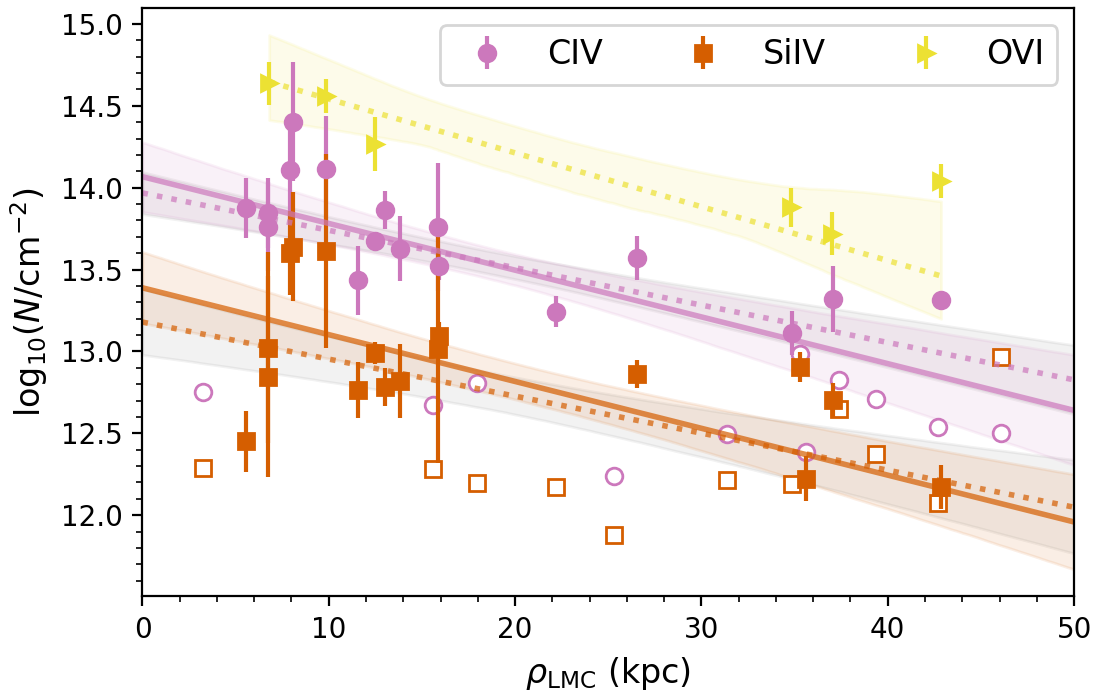

In [131]:
fig,ax = plt.subplots(constrained_layout = True, figsize = (5.5, 3.5))

axd = {"A":ax}


palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0



axd["A"].plot(xC[upper_lim_C], yC[upper_lim_C], "o",
                 markeredgecolor = palette[1], markerfacecolor = "w", markersize = 6)


axd["A"].plot(xS[upper_lim_S], yS[upper_lim_S], "s",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)




# #add arrows
# for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
# for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




axd["A"].errorbar(xC[~upper_lim_C], yC[~upper_lim_C], 
                  yC_err[~upper_lim_C], fmt = "o", 
                  color=palette[1], label = "CIV")
axd["A"].errorbar(xS[~upper_lim_S], yS[~upper_lim_S], 
                  yS_err[~upper_lim_S], fmt = "s",
                  color=palette[0], label = "SiIV")



axd["A"].errorbar(OVI_data["LMC_B"][~OVI_upper_lim_H2], OVI_data["OVI"][~OVI_upper_lim_H2], 
                  OVI_data["OVI_err"][~OVI_upper_lim_H2], fmt = ">",
                  color=pal[8], label = "OVI")

axd["A"].errorbar(OVI_data["LMC_B"][OVI_upper_lim_H2], OVI_data["OVI"][OVI_upper_lim_H2], 
                  OVI_data["OVI_err"][OVI_upper_lim_H2], fmt = ">",
                  markeredgecolor=pal[8], markerfacecolor = "w", ecolor = pal[7])



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)

axd["A"].plot(O_xx, mean_line_O, color = pal[8], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(O_xx, lo_line_O, hi_line_O, color = pal[8], alpha = 0.1)




xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 3)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlim(0,50)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/png/Figure2.png", dpi = 300, 
            transparent = True)
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/svg/Figure2.svg", 
            transparent = True)

In [57]:
OVI_data

{'OVI': array([14.26769322, 14.28524174, 13.92936691, 14.03921102,  1.14643814]),
 'OVI_err': array([0.16597611, 0.38622434, 0.71674072, 0.10288315, 0.00247991]),
 'LMC_B': <Quantity [12.48654041,  9.86112393, 37.04679733, 42.86609215, 34.8       ] kpc>,
 'SOURCE': array(['1H0419-577', 'ESO031-G08', 'HE0226-4110', 'IRAS_F21325-6237',
        'RBS144'], dtype='<U16'),
 'HII_CIE': array([18.24525322, 18.26280174, 17.90692691, 18.01677102,  5.12399814]),
 'HII_ISOB': array([19.31524322, 19.33279174, 18.97691691, 19.08676102,  6.19398814]),
 'HII_ISOCh': array([19.35238322, 19.36993174, 19.01405691, 19.12390102,  6.23112814]),
 'HII_CIE_err': array([0.16597611, 0.38622434, 0.71674072, 0.10288315, 0.00247991]),
 'HII_ISOB_err': array([0.16597611, 0.38622434, 0.71674072, 0.10288315, 0.00247991]),
 'HII_ISOCh_err': array([0.16597611, 0.38622434, 0.71674072, 0.10288315, 0.00247991]),
 'CIE_MASS': (7.618079192614633, 4.378673748751563, 0.2795247480733245),
 'ISOB_MASS': (8.688069192614634, 4.37

In [41]:
maximal_interface_obs = QTable.read("Data/MaxInterface_Cols.fits")

In [42]:
maximal_interface_obs

SOURCE,LMC_B,N_CIV,N_SiIV,N_OVI
,kpc,,,
bytes23,float64,float64,float64,float64
PKS0637-75,6.738090605662797,10000000000000.0,1320000000000.0,12800000000000.0
HE0246-4101,35.27897737979494,7500000000000.0,990000000000.0,9600000000000.0
...,...,...,...,...
HE2305-5315,46.05462368263959,5000000000000.0,660000000000.0,6400000000000.0
FAIRALL9,25.29519036625726,12100000000000.0,1630000000000.0,17200000000000.0


In [133]:
central_interface_obs = QTable.read("Data/CentralInterface_Cols.fits")

<IPython.core.display.Javascript object>


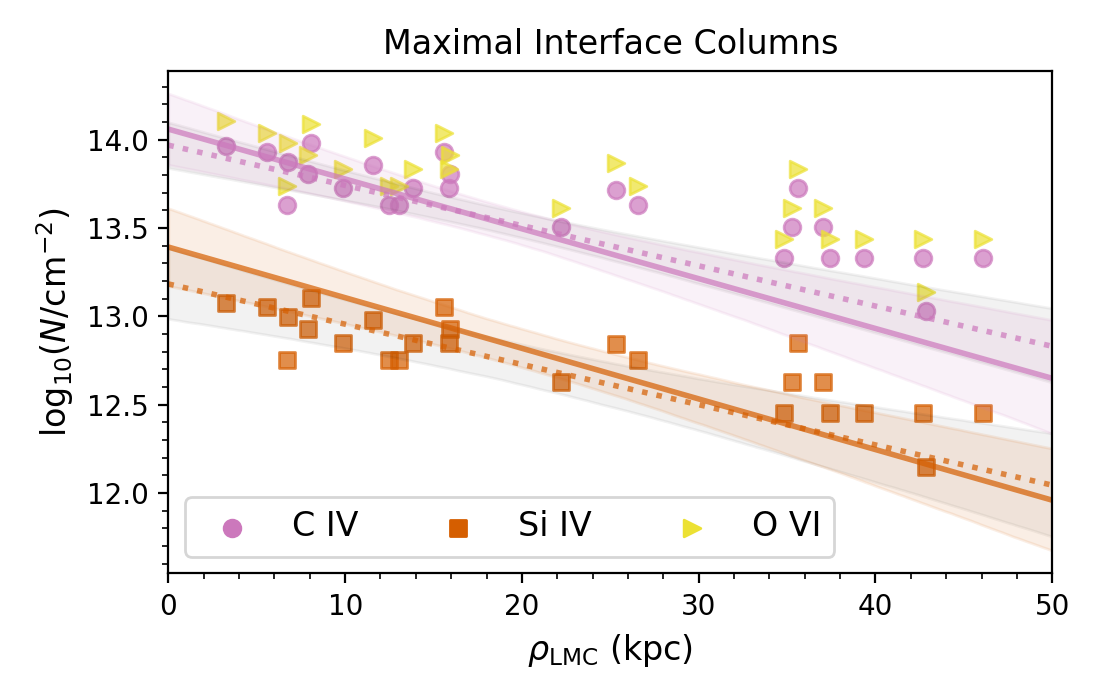

In [112]:
fig,ax = plt.subplots(figsize = (5.5, 3.5))

axd = {"A":ax}


palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0


ax.scatter(maximal_interface_obs["LMC_B"], np.log10(maximal_interface_obs["N_CIV"] * (10**-0.67/.1)*2), color = pal[4], 
           label = "C IV", alpha = 0.7)

ax.scatter(maximal_interface_obs["LMC_B"], np.log10(maximal_interface_obs["N_SiIV"]* (10**-0.67/.1)*2), color = pal[3], 
           marker = "s", label = "Si IV", alpha = 0.7)

ax.scatter(maximal_interface_obs["LMC_B"], np.log10(maximal_interface_obs["N_OVI"]* (10**-0.67/.1)*2), color = pal[8], 
           marker = ">", label = "O VI", alpha = 0.7)



# axd["A"].plot(xC[upper_lim_C], yC[upper_lim_C], "o",
#                  markeredgecolor = palette[1], markerfacecolor = "w", markersize = 6)


# axd["A"].plot(xS[upper_lim_S], yS[upper_lim_S], "s",
#                  markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

# #add arrows
# for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
# for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




# axd["A"].errorbar(xC[~upper_lim_C], yC[~upper_lim_C], 
#                   yC_err[~upper_lim_C], fmt = "o", 
#                   color=palette[1], label = "CIV")
# axd["A"].errorbar(xS[~upper_lim_S], yS[~upper_lim_S], 
#                   yS_err[~upper_lim_S], fmt = "s",
#                   color=palette[0], label = "SiIV")



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)



xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 3)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlim(0,50)

ax.set_title("Maximal Interface Columns")

fig.tight_layout()

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/png/ExtFigure8.png", 
            dpi = 300, 
            transparent = True)
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/svg/ExtFigure8.svg", 
            transparent = True)


<IPython.core.display.Javascript object>


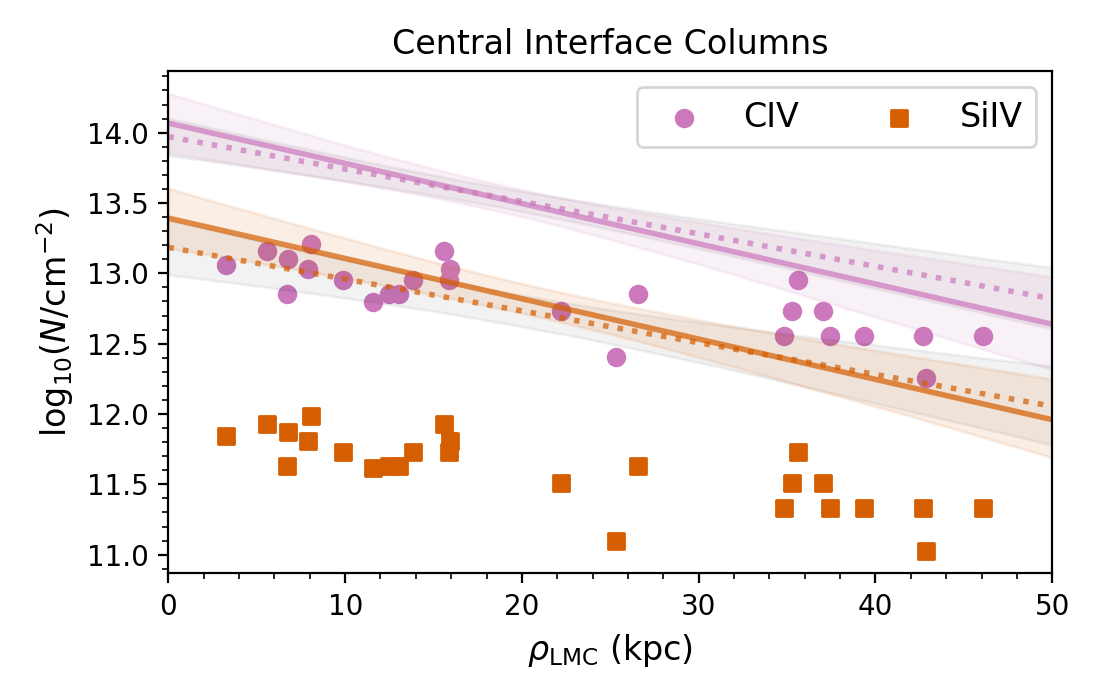

In [135]:
fig,ax = plt.subplots(figsize = (5.5, 3.5))

axd = {"A":ax}


palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0


ax.scatter(maximal_interface_obs["LMC_B"], np.log10(central_interface_obs["N_CIV"] * (10**-0.67/.1)*2), color = pal[4], 
           label = "CIV")

ax.scatter(maximal_interface_obs["LMC_B"], np.log10(central_interface_obs["N_SiIV"]* (10**-0.67/.1)*2), color = pal[3], 
           marker = "s", label = "SiIV")



# axd["A"].plot(xC[upper_lim_C], yC[upper_lim_C], "o",
#                  markeredgecolor = palette[1], markerfacecolor = "w", markersize = 6)


# axd["A"].plot(xS[upper_lim_S], yS[upper_lim_S], "s",
#                  markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

# #add arrows
# for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
# for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




# axd["A"].errorbar(xC[~upper_lim_C], yC[~upper_lim_C], 
#                   yC_err[~upper_lim_C], fmt = "o", 
#                   color=palette[1], label = "CIV")
# axd["A"].errorbar(xS[~upper_lim_S], yS[~upper_lim_S], 
#                   yS_err[~upper_lim_S], fmt = "s",
#                   color=palette[0], label = "SiIV")



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)



xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlim(0,50)

ax.set_title("Central Interface Columns")

fig.tight_layout()

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/CentralInterface.png", dpi = 300, 
            transparent = True)
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/CentralInterface.svg", transparent = True)


In [136]:
matched_inds_C = [np.argmax(maximal_interface_obs["LMC_B"].value == b) for b in xC[~upper_lim_C]]

matched_inds_S = [np.argmax(maximal_interface_obs["LMC_B"].value == b) for b in xS[~upper_lim_S]]

C_interface_diff = yC[~upper_lim_C] - np.log10(maximal_interface_obs["N_CIV"][matched_inds_C] * 
                                               (10**-0.67/.1) * 2)

C_interface_diff_err = yC_err[~upper_lim_C]

Si_interface_diff = yS[~upper_lim_S] - np.log10(maximal_interface_obs["N_SiIV"][matched_inds_S] * 
                                               (10**-0.67/.1) * 2)

Si_interface_diff_err = yS_err[~upper_lim_S]

In [137]:
from scipy.stats import wilcoxon
from seaborn.algorithms import bootstrap

In [138]:
def boot_Cwilcoxon(inds, data_arr = C_interface_diff, 
                   errs = C_interface_diff_err):
    res = wilcoxon(data_arr[inds]+errs[inds]*np.random.randn(len(inds)), alternative = "greater")
    return [res.statistic, res.pvalue]
def boot_Siwilcoxon(inds, data_arr = Si_interface_diff, 
                   errs = Si_interface_diff_err):
    res = wilcoxon(data_arr[inds]+errs[inds]*np.random.randn(len(inds)), alternative = "greater")
    return [res.statistic, res.pvalue]


C_boot_wilcoxon = bootstrap(np.arange(len(C_interface_diff), dtype = int), 
                            func = boot_Cwilcoxon, 
                            nboot = 10000)

Si_boot_wilcoxon = bootstrap(np.arange(len(Si_interface_diff), dtype = int), 
                            func = boot_Siwilcoxon, 
                            nboot = 10000)

In [139]:
print(np.sum(Si_boot_wilcoxon[:,1] < .01)/1e4)
print(np.sum(C_boot_wilcoxon[:,1] < .01)/1e4)

0.0745
0.0087


In [140]:
np.percentile(C_boot_wilcoxon[:,1], (16,50,84))

array([0.16447449, 0.51838684, 0.84697723])

In [141]:
np.percentile(Si_boot_wilcoxon[:,1], (16,50,84))

array([0.02844238, 0.17643738, 0.51838684])

<IPython.core.display.Javascript object>


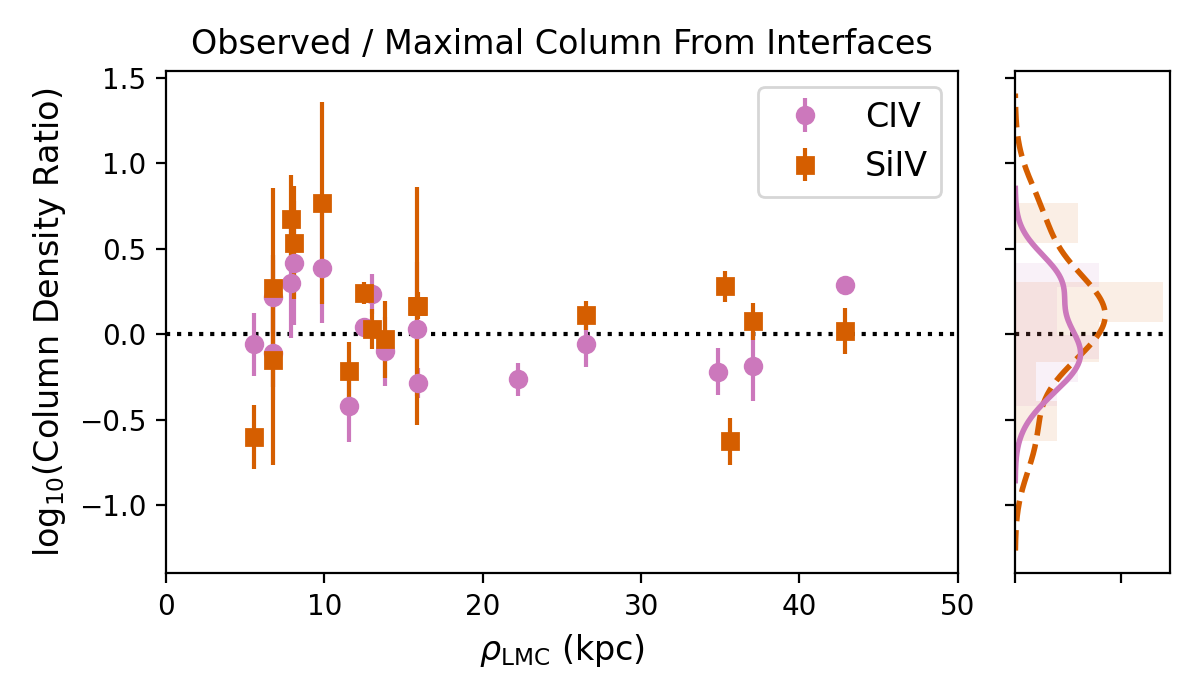

In [142]:
fig = plt.figure(figsize=(6,3.5))
gs = plt.GridSpec(5,5)

ax_joint = fig.add_subplot(gs[:, :-1])
        
ax_marg_y = fig.add_subplot(gs[:, -1], sharey=ax_joint)

plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.setp(ax_marg_y.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(minor=True), visible=False)
plt.setp(ax_marg_y.get_xticklabels(minor=True), visible=False)

axd = {"A":ax_joint}

axd["A"].errorbar(xC[~upper_lim_C], C_interface_diff, 
                  C_interface_diff_err, fmt = "o", 
                  color=palette[1], label = "CIV")
axd["A"].errorbar(xS[~upper_lim_S], Si_interface_diff, 
                  Si_interface_diff_err, fmt = "s",
                  color=palette[0], label = "SiIV")

axd["A"].axhline(0, ls = ":", color = "k", zorder = -1)

axd["A"].legend(fontsize = 12)


axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(\mathrm{Column~Density~Ratio})$", fontsize = 12)

axd["A"].set_title("Observed / Maximal Column From Interfaces", fontsize = 12)

sns.histplot(y = Si_interface_diff, color = palette[0], alpha = 0.1, kde = True, stat = "count",
            label = "SiIV", ax = ax_marg_y, 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linestyle("--") for line in ax_marg_y.lines] 

sns.histplot(y = C_interface_diff, color = palette[1], alpha = 0.1, kde = True, stat = "count",
            label = "CIV", ax = ax_marg_y, 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linewidth(2) for line in ax_marg_y.lines] 


ax_marg_y.axhline(0, ls = ":", color = "k", zorder = -1)

axd["A"].set_xlim(0,50)


fig.tight_layout()
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/MaximalInterface_Diff.png", dpi = 300, 
            transparent = True)
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/MaximalInterface_Diff.svg", 
            transparent = True)

<IPython.core.display.Javascript object>


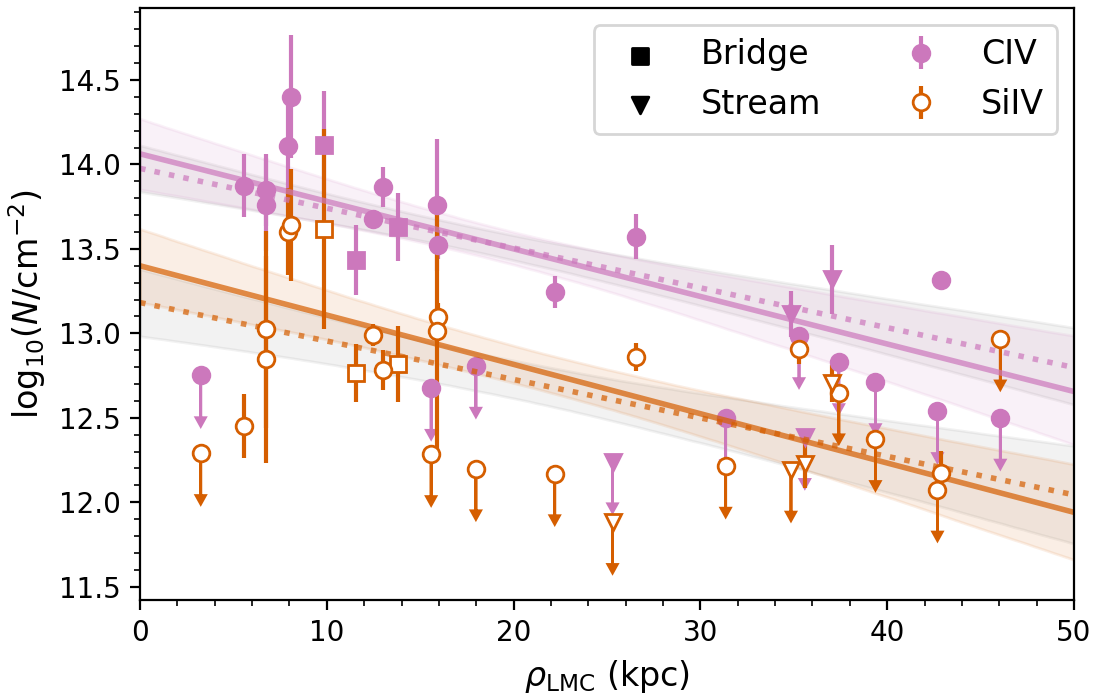

In [25]:
fig,ax = plt.subplots(constrained_layout = True, figsize = (5.5, 3.5))

axd = {"A":ax}


palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0

stream_S = np.array([x in stream_Bs for x in xS])
stream_C = np.array([x in stream_Bs for x in xC])

bridge_S = np.array([x in bridge_Bs for x in xS])
bridge_C = np.array([x in bridge_Bs for x in xC])

axd["A"].plot(xC[upper_lim_C & stream_C], yC[upper_lim_C & stream_C], "v",
                 markeredgecolor = palette[1], markerfacecolor = palette[1], markersize = 6)

axd["A"].plot(xC[upper_lim_C & ~stream_C], yC[upper_lim_C & ~stream_C], "o",
                 markeredgecolor = palette[1], markerfacecolor = palette[1], markersize = 6)

axd["A"].plot(xS[upper_lim_S & stream_S], yS[upper_lim_S & stream_S], "v",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

axd["A"].plot(xS[upper_lim_S & ~stream_S], yS[upper_lim_S & ~stream_S], "o",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

#add arrows
for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




axd["A"].errorbar(xC[~upper_lim_C & stream_C], yC[~upper_lim_C & stream_C], 
                  yC_err[~upper_lim_C & stream_C], fmt = "v", 
                  color=palette[1])
axd["A"].errorbar(xS[~upper_lim_S & stream_S], yS[~upper_lim_S & stream_S], 
                  yS_err[~upper_lim_S & stream_S], fmt = "v",
                  color=palette[0], mfc = "w")

axd["A"].errorbar(xC[~upper_lim_C & bridge_C], yC[~upper_lim_C & bridge_C], 
                  yC_err[~upper_lim_C & bridge_C], fmt = "s", 
                  color=palette[1])
axd["A"].errorbar(xS[~upper_lim_S & bridge_S], yS[~upper_lim_S & bridge_S], 
                  yS_err[~upper_lim_S & bridge_S], fmt = "s",
                  color=palette[0], mfc = "w")

axd["A"].errorbar(xC[~upper_lim_C & ~stream_C & ~bridge_C], yC[~upper_lim_C & ~stream_C & ~bridge_C], 
                  yC_err[~upper_lim_C & ~stream_C & ~bridge_C], fmt = "o", 
                  color=palette[1], label = "CIV")
axd["A"].errorbar(xS[~upper_lim_S & ~stream_S & ~bridge_S], yS[~upper_lim_S & ~stream_S & ~bridge_S], 
                  yS_err[~upper_lim_S & ~stream_S & ~bridge_S], fmt = "o",
                  color=palette[0], label = "SiIV", mfc = "w")

axd["A"].scatter([20],[14.5], marker = "s", facecolor="k", edgecolor = "k", alpha = 0., label = "Bridge")
axd["A"].scatter([20],[14.5], marker = "v", facecolor="k", edgecolor = "k", alpha = 0., label = "Stream")



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)



xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlim(0,50)



<IPython.core.display.Javascript object>


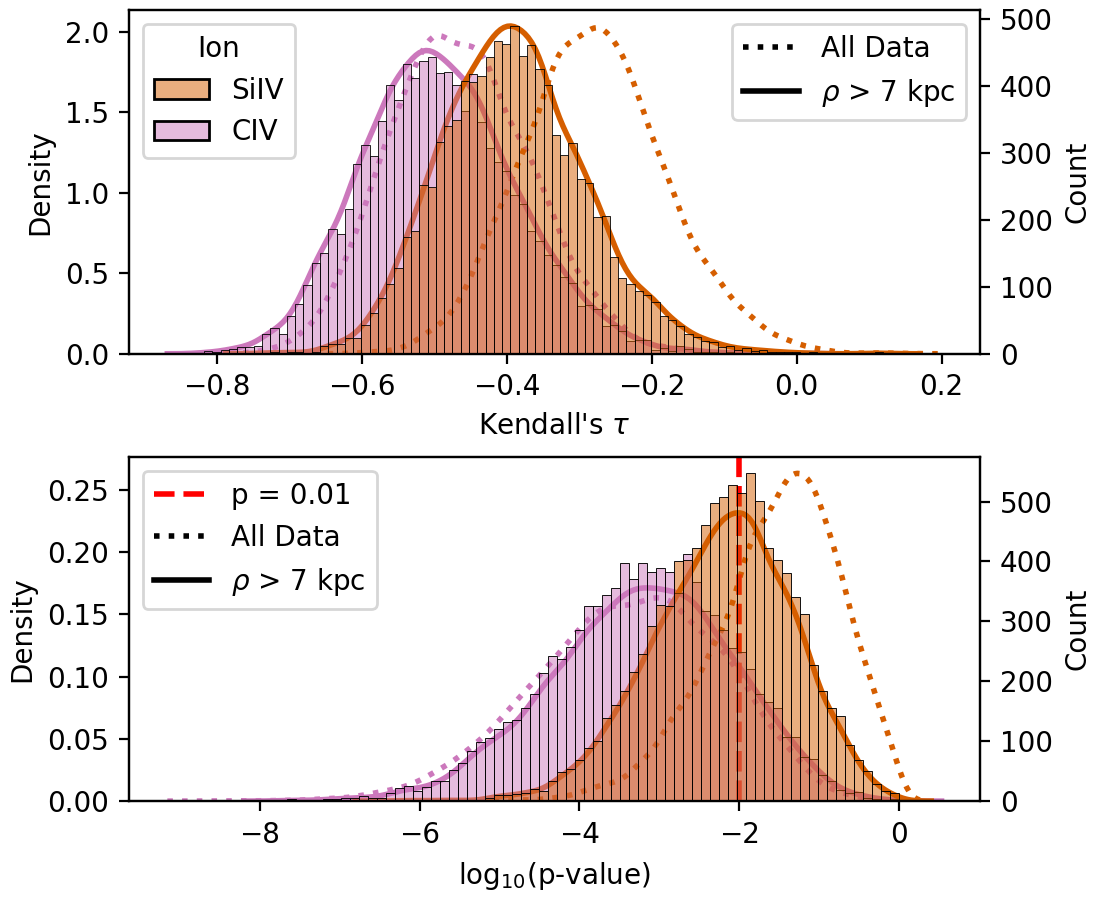

In [11]:
fig,axs = plt.subplots(2,1,constrained_layout = True, figsize = (5.5, 4.5))

axd = {"B":axs[0], "C":axs[1]}


palette = [pal[3], pal[4]]



sns.kdeplot(data = mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
            ax = axd["B"], legend = False, ls = ":", lw = 2)
sns.kdeplot(data = gt7_mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
            ax = axd["B"], legend = False, ls = "-", lw = 2)

axt = axd["B"].twinx()
sns.histplot(data = gt7_mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
             ax = axt, legend = True)

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
move_legend(axt, "upper left")

axd["B"].axvline(-0.5, ls = ":", color = "k", alpha = 0, label = "All Data", lw = 2)
axd["B"].axvline(-0.5, ls = "-", color = "k", alpha = 0, label = r"$\rho$ > 7 kpc", lw = 2)

lg = axd["B"].legend(loc = 1)
for lh in lg.legendHandles: 
    lh.set_alpha(1)



sns.kdeplot(data = mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
            ax = axd["C"], legend = False, lw = 2, ls = ":")
sns.kdeplot(data = gt7_mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
            ax = axd["C"], legend = False, lw = 2, ls = "-")
axt2 = axd["C"].twinx()
sns.histplot(data = gt7_mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
             ax = axt2, legend = False)

axd["C"].axvline(np.log10(0.01), ls = "--", color = "r", label = "p = 0.01", lw = 2)
axd["C"].axvline(-0.5, ls = ":", color = "k", alpha = 0, label = "All Data", lw = 2)
axd["C"].axvline(-0.5, ls = "-", color = "k", alpha = 0, label = r"$\rho$ > 7 kpc", lw = 2)

lg = axd["C"].legend(loc = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)


<IPython.core.display.Javascript object>


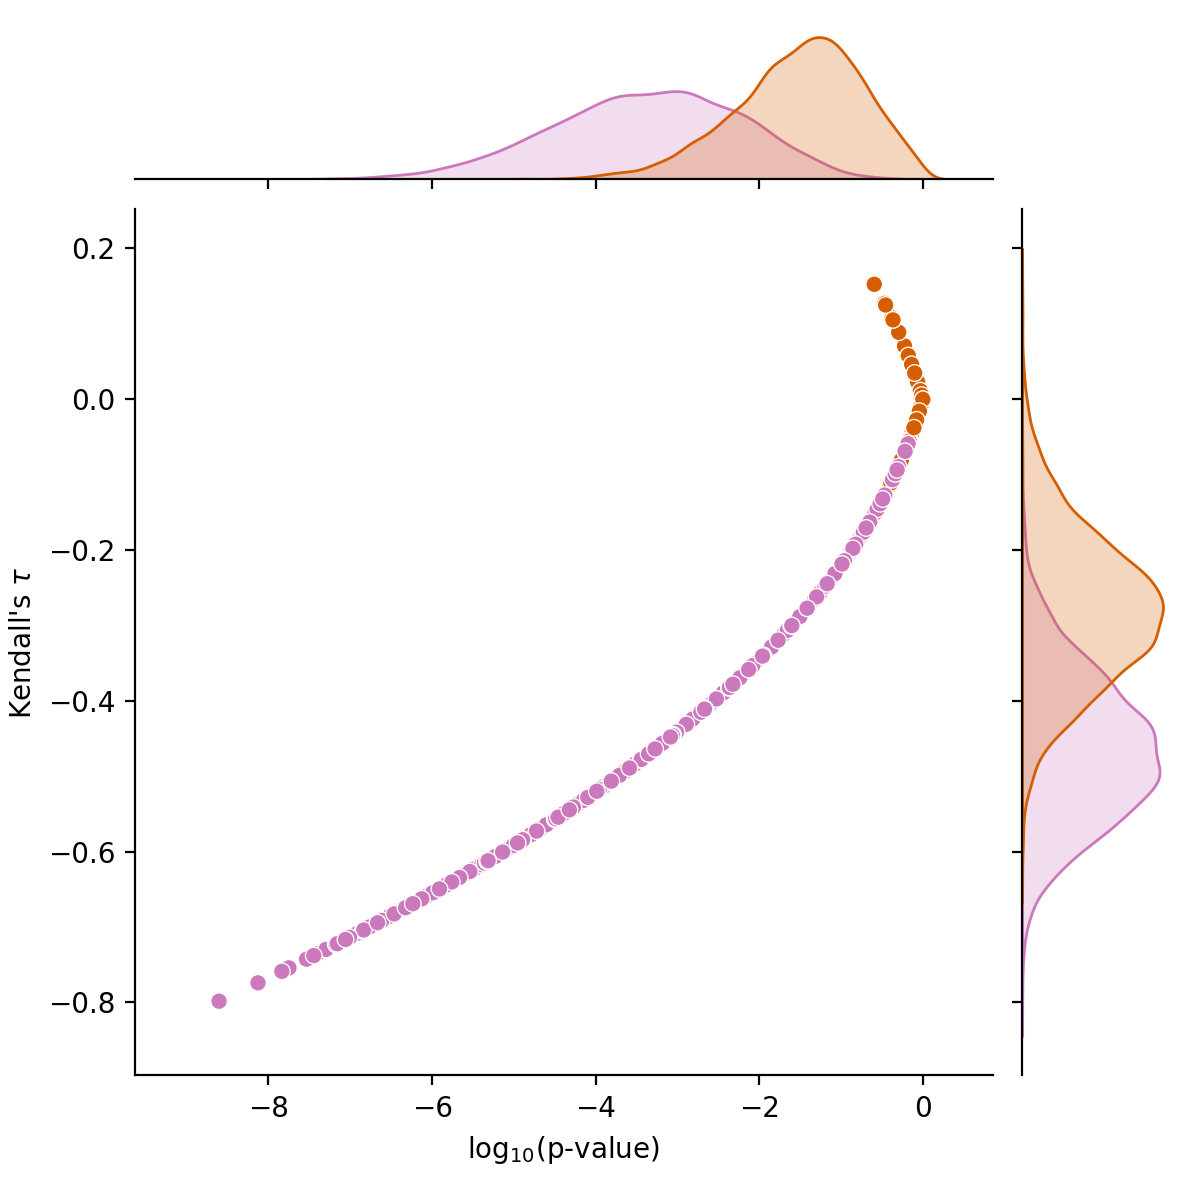

In [14]:
g = sns.jointplot(data = mc_data, hue = "Ion", palette = palette, 
            legend = False, 
                  y = r"Kendall's $\tau$", 
                  x = r"$\log_{10}$(p-value)", kind = "scatter")

<IPython.core.display.Javascript object>


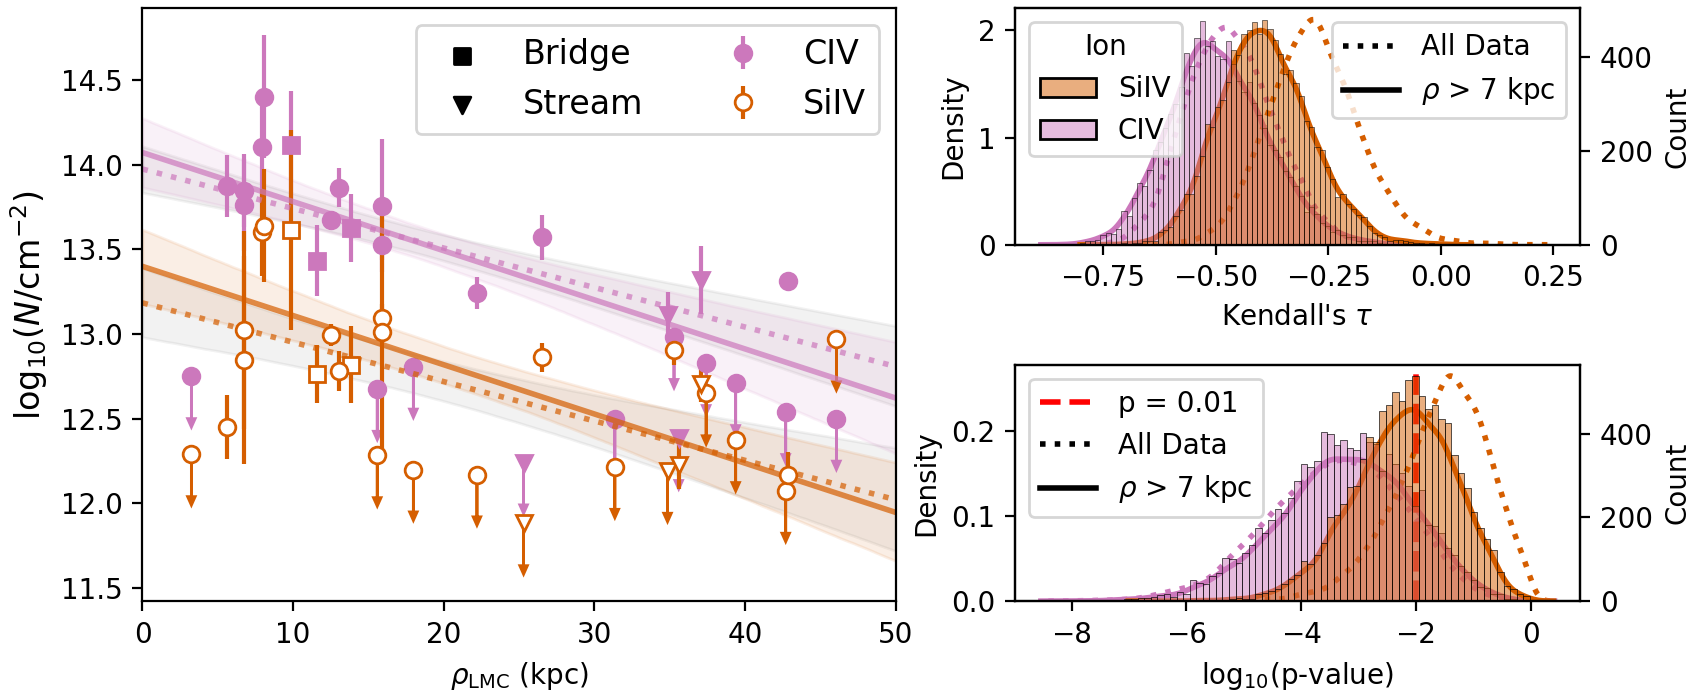

In [18]:
fig = plt.figure(constrained_layout = True, figsize = (8.5,3.5))



axd = fig.subplot_mosaic("""
AAAABBB
AAAACCC
""")

palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0

stream_S = np.array([x in stream_Bs for x in xS])
stream_C = np.array([x in stream_Bs for x in xC])

bridge_S = np.array([x in bridge_Bs for x in xS])
bridge_C = np.array([x in bridge_Bs for x in xC])

axd["A"].plot(xC[upper_lim_C & stream_C], yC[upper_lim_C & stream_C], "v",
                 markeredgecolor = palette[1], markerfacecolor = palette[1], markersize = 6)

axd["A"].plot(xC[upper_lim_C & ~stream_C], yC[upper_lim_C & ~stream_C], "o",
                 markeredgecolor = palette[1], markerfacecolor = palette[1], markersize = 6)

axd["A"].plot(xS[upper_lim_S & stream_S], yS[upper_lim_S & stream_S], "v",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

axd["A"].plot(xS[upper_lim_S & ~stream_S], yS[upper_lim_S & ~stream_S], "o",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)

#add arrows
for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
    axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




axd["A"].errorbar(xC[~upper_lim_C & stream_C], yC[~upper_lim_C & stream_C], 
                  yC_err[~upper_lim_C & stream_C], fmt = "v", 
                  color=palette[1])
axd["A"].errorbar(xS[~upper_lim_S & stream_S], yS[~upper_lim_S & stream_S], 
                  yS_err[~upper_lim_S & stream_S], fmt = "v",
                  color=palette[0], mfc = "w")

axd["A"].errorbar(xC[~upper_lim_C & bridge_C], yC[~upper_lim_C & bridge_C], 
                  yC_err[~upper_lim_C & bridge_C], fmt = "s", 
                  color=palette[1])
axd["A"].errorbar(xS[~upper_lim_S & bridge_S], yS[~upper_lim_S & bridge_S], 
                  yS_err[~upper_lim_S & bridge_S], fmt = "s",
                  color=palette[0], mfc = "w")

axd["A"].errorbar(xC[~upper_lim_C & ~stream_C & ~bridge_C], yC[~upper_lim_C & ~stream_C & ~bridge_C], 
                  yC_err[~upper_lim_C & ~stream_C & ~bridge_C], fmt = "o", 
                  color=palette[1], label = "CIV")
axd["A"].errorbar(xS[~upper_lim_S & ~stream_S & ~bridge_S], yS[~upper_lim_S & ~stream_S & ~bridge_S], 
                  yS_err[~upper_lim_S & ~stream_S & ~bridge_S], fmt = "o",
                  color=palette[0], label = "SiIV", mfc = "w")

axd["A"].scatter([20],[14.5], marker = "s", facecolor="k", edgecolor = "k", alpha = 0., label = "Bridge")
axd["A"].scatter([20],[14.5], marker = "v", facecolor="k", edgecolor = "k", alpha = 0., label = "Stream")



xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)



xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)")
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)




sns.kdeplot(data = mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
            ax = axd["B"], legend = False, ls = ":", lw = 2)
sns.kdeplot(data = gt7_mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
            ax = axd["B"], legend = False, ls = "-", lw = 2)

axt = axd["B"].twinx()
sns.histplot(data = gt7_mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
             ax = axt, legend = True)

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
move_legend(axt, "upper left")

axd["B"].axvline(-0.5, ls = ":", color = "k", alpha = 0, label = "All Data", lw = 2)
axd["B"].axvline(-0.5, ls = "-", color = "k", alpha = 0, label = r"$\rho$ > 7 kpc", lw = 2)

lg = axd["B"].legend(loc = 1)
for lh in lg.legendHandles: 
    lh.set_alpha(1)



sns.kdeplot(data = mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
            ax = axd["C"], legend = False, lw = 2, ls = ":")
sns.kdeplot(data = gt7_mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
            ax = axd["C"], legend = False, lw = 2, ls = "-")
axt2 = axd["C"].twinx()
sns.histplot(data = gt7_mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
             ax = axt2, legend = False)

axd["C"].axvline(np.log10(0.01), ls = "--", color = "r", label = "p = 0.01", lw = 2)
axd["C"].axvline(-0.5, ls = ":", color = "k", alpha = 0, label = "All Data", lw = 2)
axd["C"].axvline(-0.5, ls = "-", color = "k", alpha = 0, label = r"$\rho$ > 7 kpc", lw = 2)

lg = axd["C"].legend(loc = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)
# axd["C"].legend(fontsize = 10)

_ = axd["A"].set_xlim(0,50)


In [86]:
OVI_data

{'OVI': array([14.26769322, 14.46251005, 13.92936691, 14.03921102, 14.12884304]),
 'OVI_err': array([0.16597611, 0.4773693 , 0.71674072, 0.10288315, 0.12014598]),
 'LMC_B': <Quantity [12.48654041,  9.86112393, 37.04679733, 42.86609215, 34.84783719] kpc>,
 'SOURCE': array(['1H0419-577', 'ESO031-G08', 'HE0226-4110', 'IRAS_F21325-6237',
        'RBS144'], dtype='<U16')}